<a href="https://colab.research.google.com/github/iamcbn/NumPy-vs.-scikit-learn-StandardScaler/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WRITE UP

## INTRODUCTION

It is funny how this came about. I was having a discussion with a friend about a tweet we saw. An interviewer asked someone to write a StandardScaler using NumPy as a practice run, so we gave it a go. I noticed the NumPy version felt faster than scikit-learn’s StandardScaler, so I ran a proper test to see whether that intuition holds up. The motivation is practical: in real pipelines small per-call speedups can add up, and if a transform is called many times or inside loops it could create a noticeable drag on throughput.

## What I tested

I compared only transform (not fit or fit_transform) between:

- scikit-learn’s StandardScaler.transform

- a manual NumPy/Pandas implementation doing the equivalent operations

Each trial measured elapsed time for a single transform. I ran 100,000 paired trials (same inputs for each pair) and stored the per-trial times.

## Key summary statistics:

- n = 100,000

- scikit-learn mean time = 0.593490 ms

- manual mean time = 0.310246 ms

- mean difference (sklearn − manual) = 0.283244 ms

- standard deviation of differences = 0.107049 ms

- Shapiro test on differences: W $\approx$ 0.566, p $<<$ 0.001 → not normal

- paired t statistic $\approx$ 836.72, one-sided p $\approx$ 0

- Wilcoxon statistic $\approx$ 7,211,668.5, one-sided p $\approx$ 0

- Cohen’s d (paired) $\approx$ 2.646
  

## What does this mean?

Manual is faster on average by 0.283ms per transform, which is about 47.7% faster than scikit-learn’s transform (0.283 / 0.593 ≈ 47.7%).

The Shapiro test shows the difference distribution is highly skewed (not normal). Because of that, I relied on the Wilcoxon signed-rank test (non-parametric) in addition to the t-test. Both tests give essentially zero p-value, so the result is statistically significant either way.

Cohen’s d of about 2.65 is a very large effect. A value above 0.8 is usually considered large. Due to this is a strong, it is practically meaningful effect.

## Does this matters?

A saving of 0.283 ms per transform may sound tiny, but it compounds when transforms are repeated or applied at scale:

- 1,000 transforms: ~0.283 seconds saved

- 1,000,000 transforms: ~283.24 seconds saved (about 4.72 minutes)
If your pipeline calls transform many times (for many batches, for many requests, or inside iterative loops), this saving becomes meaningful.

## Caveats and limitations

- Measurements depend on the environment: CPU, memory state, Python/NumPy versions, scikit-learn version, and background load all affect timings.

- Transform method was only measured. If a pipeline does fit, fit+transform or calls these inside model retraining, the relative advantage may change.

- Microbenchmarks can be brittle. Things like caching, first-call overhead, vector length and memory layout, and multithreading inside BLAS/NumPy can change the outcome.


## Conclusion

Manual NumPy StandardScaler.transform is reliably faster than scikit-learn’s transform in these tests — about 0.283 ms faster per call ($\approx$48% speedup), with a very large effect size and a tight 95% CI. The difference is statistically and practically meaningful when transforms are called at scale.

## Devil's Advocate

Scikit-learn's still remains industry's standard due to easy pipeline integration.

# CODE BASE

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler as SKStandardScaler
import matplotlib.pyplot as plt
import time
import scipy.stats as stats
import seaborn as sns

In [ ]:
class StandardScaler():
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.columns = None
        self.is_dataframe = False
        self.is_fitted = False

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            self.is_dataframe = True
            self.columns = X.select_dtypes(include='number').columns
            self.mean_ = X[self.columns].mean(axis=0)
            self.std_ = X[self.columns].std(axis=0, ddof=0)
            self.is_fitted = True
        else:
            self.mean_ = np.mean(X, axis=0)
            self.std_ = np.std(X, axis=0)
            self.is_fitted = True
        return self


    def transform(self, X):
        if self.is_fitted is False:
            raise RuntimeError("This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.")
        if self.is_dataframe is True and isinstance(X, pd.DataFrame):
            X_scaled = X.copy()
            X_scaled[self.columns] = (X_scaled[self.columns] - self.mean_) / self.std_
            return X_scaled
        else:
            X_arr = np.asarray(X)
            X_arr = (X_arr - self.mean_) / self.std_
            return X_arr

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        if self.is_fitted is False:
            raise Exception("This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.")
        if self.is_dataframe is True and isinstance(X, pd.DataFrame):
            X_original = X.copy()
            X_original[self.columns] = (X[self.columns] * self.std_) + self.mean_
            return X_original
        else:
            X_arr = np.asarray(X)
            X_arr = (X_arr * self.std_) + self.mean_
            return X_arr



In [ ]:
def benchmark_time(X):
    # measuring sklearn transform time
    sk = SKStandardScaler()
    sk.fit(X)
    t0 = time.perf_counter()
    sk.transform(X)
    t1 = time.perf_counter()

    # measuring manual transform time
    manual = StandardScaler()
    manual.fit(X)
    t2 = time.perf_counter()
    manual.transform(X)
    t3 = time.perf_counter()
    return (t1 - t0), (t3 - t2)


def run_benchmark(n_runs=10000, n_samples=2000, n_features=50, dtype=np.float64, seed=2515):
    rng = np.random.RandomState(seed)
    times_sk = []
    times_manual = []

    for i in range(n_runs):
        X = rng.randn(n_samples, n_features).astype(dtype)
        tsk, tmanual = benchmark_time(X)
        times_sk.append(tsk)
        times_manual.append(tmanual)

    return np.array(times_sk), np.array(times_manual)


def summary_stat(times_sk, times_manual):
  diff = times_sk - times_manual  # positive -> sklearn slower -> manual faster
  out = {}
  out['n'] = len(diff)
  out['sk_mean'] = times_sk.mean()
  out['sk_median'] = np.median(times_sk)
  out['manual_mean'] = times_manual.mean()
  out['manual_median'] = np.median(times_manual)
  out['mean_diff'] = diff.mean()
  out['median_diff'] = np.median(diff)
  out['std_diff'] = diff.std(ddof=1)

  return out

def inferential_stat(times_sk, times_manual, out, alpha = 0.05):
    diff = times_sk - times_manual  # positive -> sklearn slower -> manual faster

    # Shapiro's test -> to test for nomality as t-test needs a assumes the distribution is normal
    out['shapiro_diff'] = stats.shapiro(diff)  # returns (stat, p)

    # Checking for normaility on shapiro test.
    if out['shapiro_diff'][1] >= alpha:
      out['is_normal'] = True
    else:
      out['is_normal'] = False

    # Paired t-test based
    t_stat, p_two_sided = stats.ttest_rel(times_sk, times_manual)
    # One-sided p-value for hypothesis "manual faster" (i.e. mean_diff > 0)
    if t_stat > 0:
        p_one_sided = p_two_sided / 2
    else:
        p_one_sided = 1 - p_two_sided / 2
    out['t_stat'] = t_stat
    #out['p_two_sided'] = p_two_sided
    out['p_one_sided'] = p_one_sided

    # Wilcoxon (non-parametric) signed-rank test
    w_stat, w_p_two_sided = stats.wilcoxon(diff)
    if w_stat > 0:
        w_p_one_sided = w_p_two_sided / 2
    else:
        w_p_one_sided = 1 - w_p_two_sided / 2
    out['wilcoxon_stat'] = w_stat
    out['wilcoxon_p_one_sided'] = w_p_one_sided


    # Effect size: Cohen's d for paired samples
    out['cohen_d_paired'] = diff.mean() / diff.std(ddof=1)

    return out

def plot_results(times_sk, times_manual):
    # Box plot manual and sklearn time comparison
    plt.figure(figsize=(9,4))
    plt.boxplot([times_sk, times_manual], tick_labels=['sklearn', 'manual'])
    plt.ylabel('Time (s)')
    plt.title('Timing comparison: sklearn vs manual (boxplot)')
    plt.grid(True, axis='y', linestyle=':', alpha=0.6)
    plt.show()

    print()

    # Histogram with KDE overlay
    plt.figure(figsize=(9, 4))
    sns.histplot(times_sk, kde=True, stat="density", alpha=0.6, label='sklearn')
    sns.histplot(times_manual, kde=True, stat="density", alpha=0.6, label='manual')
    plt.axvline(times_sk.mean(), color='green', linestyle='dashed', linewidth=1, label='sklearn mean')
    plt.axvline(times_manual.mean(), color='black', linestyle='dashed', linewidth=1, label='manual mean')
    plt.axvline(np.median(times_sk), color='red', linestyle='-', linewidth=1, label='sklearn median')
    plt.axvline(np.median(times_manual), color='blue', linestyle='-', linewidth=1, label='manual median')


    plt.xlabel('Time (s)')
    plt.ylabel('Density')
    plt.title('Histogram of timings')
    plt.legend()
    plt.show()

    print()

    # Overlapping histogram on log scale (useful when times vary)
    plt.figure(figsize=(9,4))
    plt.hist(times_sk, bins=50, alpha=0.6, label='sklearn')
    plt.hist(times_manual, bins=50, alpha=0.6, label='manual')
    plt.xscale('log')
    plt.xlabel('Time (s, log scale)')
    plt.ylabel('Frequency')
    plt.title('Histogram of timings (log scale)')
    plt.legend()
    plt.show()


In [ ]:
times_sk, times_manual = run_benchmark(n_runs=100000)

In [ ]:
result = summary_stat(times_sk, times_manual)
result

{'n': 100000,
 'sk_mean': np.float64(0.0005934900175200391),
 'sk_median': np.float64(0.0005512070000577296),
 'manual_mean': np.float64(0.0003102455894903062),
 'manual_median': np.float64(0.0003000100000463135),
 'mean_diff': np.float64(0.00028324442802973296),
 'median_diff': np.float64(0.0002568209999935789),
 'std_diff': np.float64(0.00010704919655648846)}

After studying the summary statistics, I suspect that the distribution is right skewed for both sk learn and manual StandardScaler transform time. This will be checked graphically to be sure.

Also, the mean difference between SK learn and manual shows that manual is 0.26 ms faster than SK learn on average. On average, it takes manual StandardScaler 0.31 ms per compute, which is ≈ 47.7% faster than SK learn StandardScaler transform time (0.59 ms per-trial run).

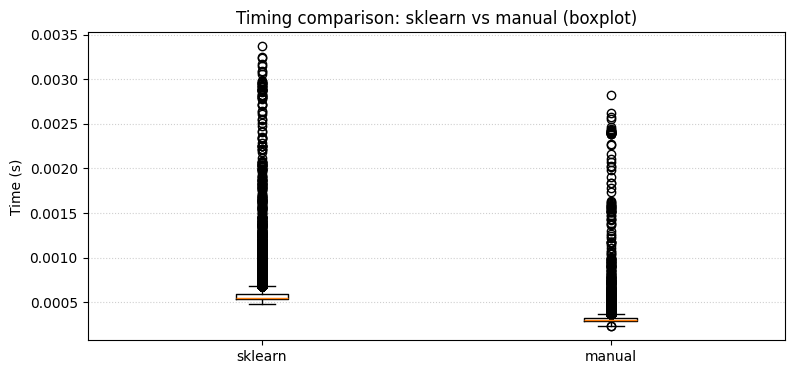

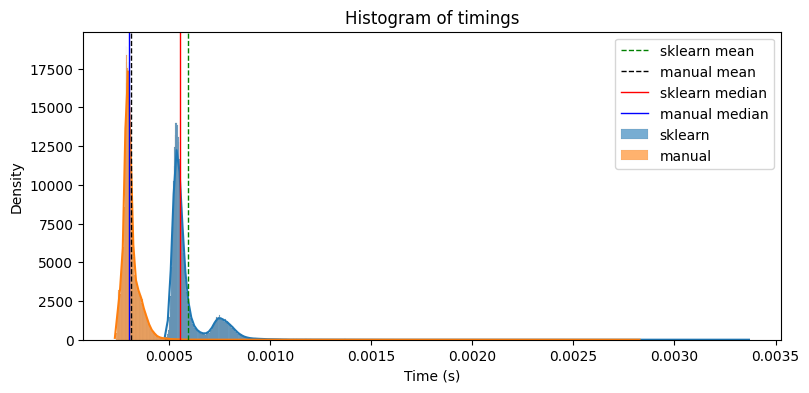

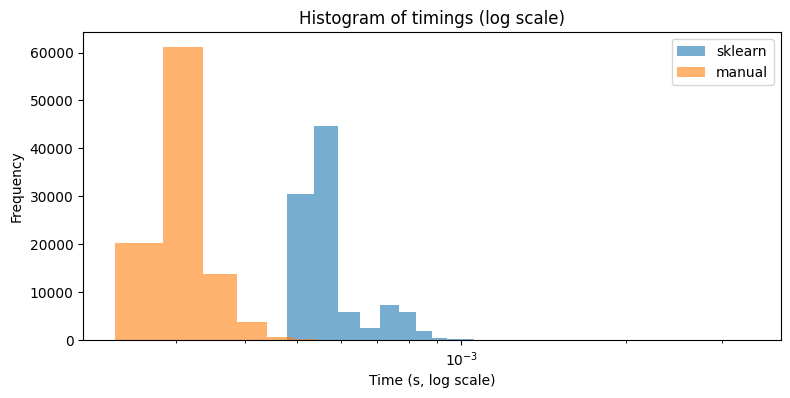

In [ ]:
plot_results(times_sk, times_manual)

From the plot above (box plot and KDE plot), it is observed that the data are not normal and are highly skewed to the right. In this case, we cannot use a parametric test. For statistical inference, it is best to use the Wilcoxon test to ascertain our next step.

Also, the graphical representation of the distribution shows that manual StandardScaler is indeed faster than SK learn derivatives.

In [ ]:
result = inferential_stat(times_sk, times_manual, result)
result

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


{'n': 100000,
 'sk_mean': np.float64(0.0005934900175200391),
 'sk_median': np.float64(0.0005512070000577296),
 'manual_mean': np.float64(0.0003102455894903062),
 'manual_median': np.float64(0.0003000100000463135),
 'mean_diff': np.float64(0.00028324442802973296),
 'median_diff': np.float64(0.0002568209999935789),
 'std_diff': np.float64(0.00010704919655648846),
 'shapiro_diff': ShapiroResult(statistic=np.float64(0.5664000784618087), pvalue=np.float64(3.4530726307570676e-156)),
 'is_normal': False,
 't_stat': np.float64(836.7157867018151),
 'p_one_sided': np.float64(0.0),
 'wilcoxon_stat': np.float64(7211668.5),
 'wilcoxon_p_one_sided': np.float64(0.0),
 'cohen_d_paired': np.float64(2.645927640197361)}

The assumption we would be testing is: Manual StandardScaler is faster than StandardScaler.

$H_0$ : Sklearn is faster or has similar speed (mean difference ≤ 0)

$H_A$ : Manual StandardScaler is faster (mean difference > 0)

$\alpha$: For this test, it was set to 0.05 to show significance.

After running the statistical tests, it has been confirmed that:

1. The distributions are highly skewed.
2. The t-statistic is huge; the one-sided p-value for the directional test (manual faster) is essentially zero. This means the observed mean difference is far outside what you would expect under the null hypothesis of no difference.
3. Wilcoxon stat and p-value = 0.0: the non-parametric test (which does not assume normality) also gives an extremely small p-value. That agrees with the t-test: the difference is definitely real.



In [ ]:
# 95% Bootstrap CI for mean difference
seed = 2515
diff = times_sk - times_manual
rng = np.random.RandomState(seed)
B = 10000
boot_means = []
n = len(diff)
for i in range(B):
    sample = rng.choice(diff, size=n, replace=True)
    boot_means.append(sample.mean())
lower, upper = np.percentile(boot_means, [2.5, 97.5])
print(lower, upper)


0.0002825814779489458 0.00028391459301482157


# Rough

In [ ]:
 # Bootstrap 95% CI for mean difference
seed = 2515
diff = times_sk - times_manual
rng = np.random.RandomState(seed)
B = 10000
boot_means = []
n = len(diff)
for i in range(B):
    sample = rng.choice(diff, size=n, replace=True)
    boot_means.append(sample.mean())
lower, upper = np.percentile(boot_means, [2.5, 97.5])
print(lower, upper)


In [ ]:
b =[[1,2,3], [4,5,6],[7,8, 100]]

data = {}
ss_data = []
sk_data = []

for i in range(1000000):
  ss_start = time.time()
  ss_model = StandardScaler()
  ss_model.fit(b)
  A = ss_model.transform(b)
  ss_stop = time.time()
  ss_diff = ss_stop - ss_start
  data['Manual time diff'] = ss_diff
  data['Manual start time'] = ss_start
  data['Manual stop time'] = ss_stop
  ss_data.append(ss_diff)


for i in range(100000):
  sk_start = time.time()
  sk_model = SKStandardScaler()
  sk_model.fit(b)
  B = sk_model.transform(b)
  sk_stop = time.time()
  sk_diff = sk_stop - sk_start
  data['Sklearn time diff'] = sk_diff
  data['Sklearn start time'] = sk_start
  data['Sklearn stop time'] = sk_stop
  sk_data.append(sk_diff)

In [ ]:
#  Mean difference

np.mean(ss_diff)
print(f'Manual time diff: {np.mean(ss_data)}\n')
print(f'Sklearn time diff: {np.mean(sk_data)}\n')
print(f'Difference: {np.mean(ss_data) - np.mean(sk_data)}\n')

if np.mean(ss_data) < np.mean(sk_data):
  print('Manual scaler is faster')
else:
  print('Sklearn scaler is faster')

Manual time diff: 5.912355899810791e-05

Sklearn time diff: 0.0006016342339515686

Difference: -0.0005425106749534607

Manual scaler is faster


In [ ]:
print(time.time() - time.time())
time.perf_counter() - time.perf_counter()

-2.384185791015625e-07


-3.039999683096539e-07